In [2]:
import numpy as np
import cv2
import glob
import time
import pickle
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from utils import *

from moviepy.editor import VideoFileClip
from IPython.display import HTML

examples_car=glob.glob('vehicles/*/*.png')
examples_noncar=glob.glob('non-vehicles/*/*.png')
print(len(examples_car),len(examples_noncar))

8792 8968


In [2]:
car_ids_random=np.random.random_integers(0,len(examples_car),10)
noncar_ids_random=np.random.random_integers(0,len(examples_noncar),10)
print(car_ids_random,noncar_ids_random)

[3357 6981 5225 8411 4227 1633 6671 5105 4860 8035] [8855 2246 8652 3806 1316 5246 3444 2820 3600 6466]


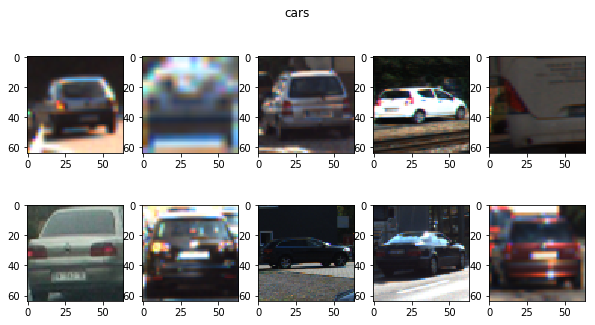

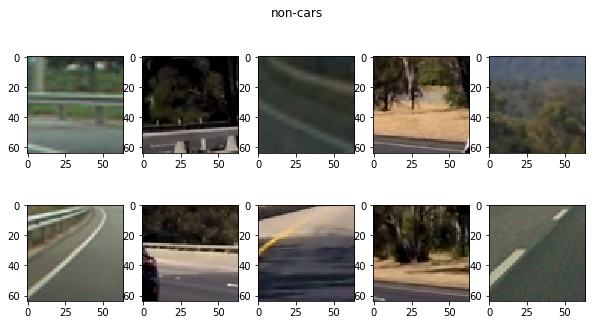

In [8]:
plt.figure(figsize=(10,5))
plt.suptitle('cars')
for i in range(10):
    image=mpimg.imread(examples_car[car_ids_random[i]])
    plt.subplot(2,5,i+1)
    plt.imshow(image)
plt.figure(figsize=(10,5))
plt.suptitle('non-cars')
for i in range(10):
    image=mpimg.imread(examples_noncar[noncar_ids_random[i]])
    plt.subplot(2,5,i+1)
    plt.imshow(image)

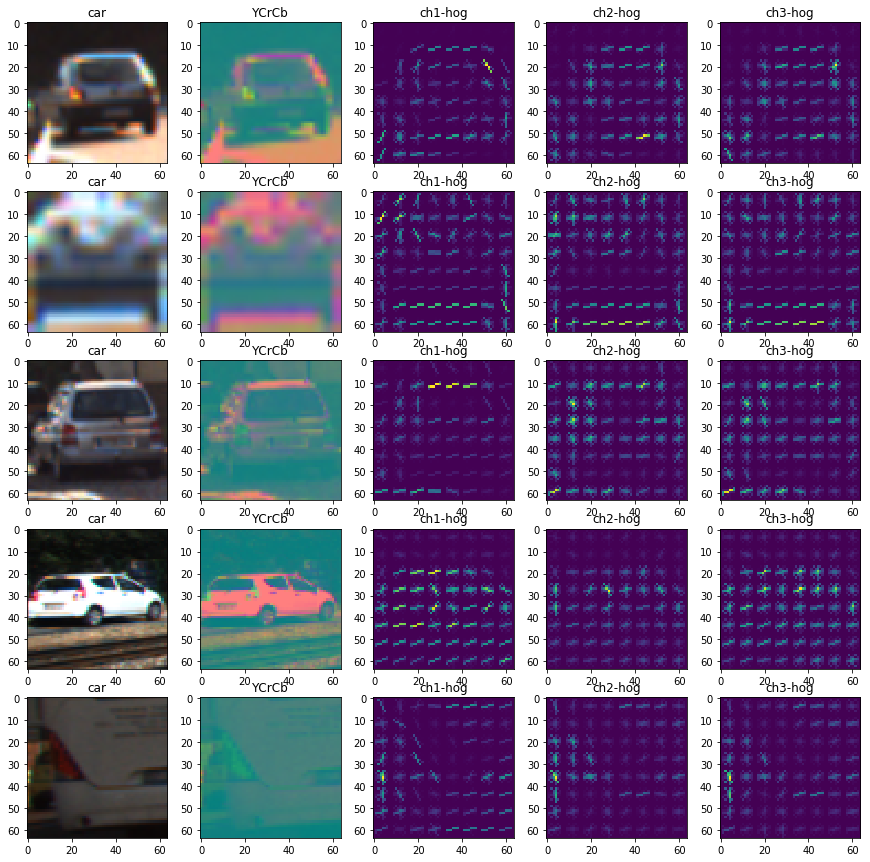

In [13]:
orient=9
pix_per_cell=8
cell_per_block=2

plt.figure(figsize=(15,15))
k=1
for i in range(5):
    image=mpimg.imread(examples_car[car_ids_random[i]])
    plt.subplot(5,5,k)
    plt.imshow(image)
    plt.title('car')
    feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    plt.subplot(5,5,k+1)
    plt.imshow(feature_image)
    plt.title('YCrCb')
    for j in range(3):
        features,hog_img=get_hog_features(feature_image[:,:,j],orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True)
        plt.subplot(5,5,k+j+2)
        plt.imshow(hog_img)
        plt.title('ch'+str(j+1)+'-hog')
    k=k+5   

In [3]:
try:
    svc
except NameError:
    with open('params.pickle','rb') as handle:
        params=pickle.load(handle)
    
    color_space=params['color_space']
    svc=params['svc']
    X_scaler=params['X_scaler']
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins']
    hog_channel=params['hog_channel']

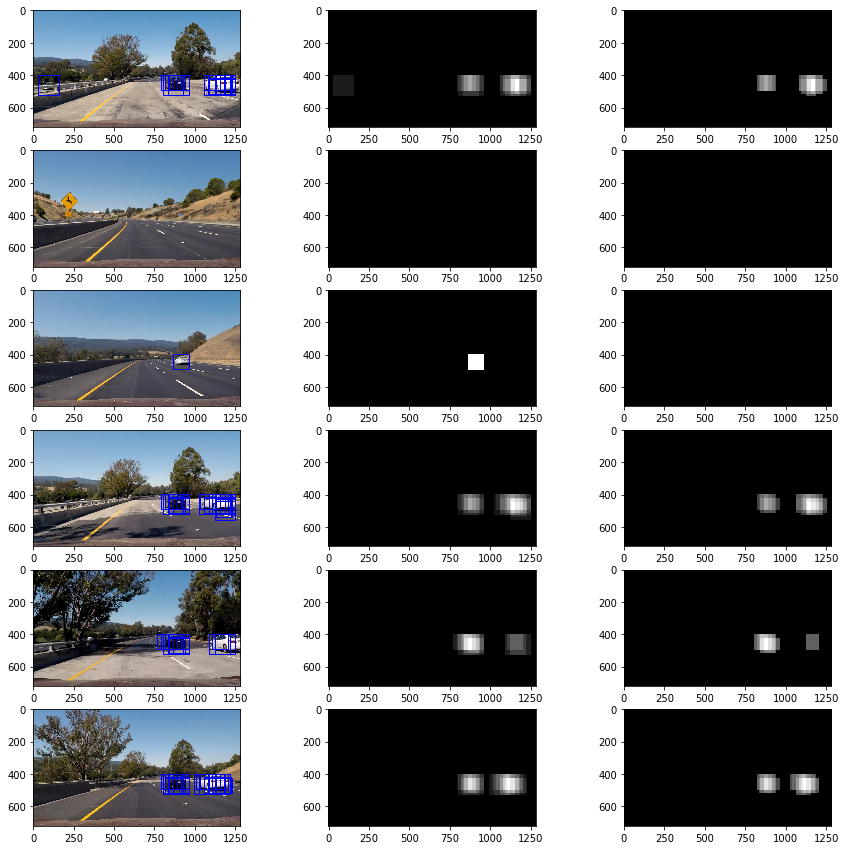

In [12]:
test_imgs_path='./test_images/'
img_files=os.listdir(test_imgs_path)

plt.figure(figsize=(15,15))
k=1
for img_file in img_files:
    if img_file.endswith('.jpg'):
        test_img_file=test_imgs_path+img_file
        test_img=mpimg.imread(test_img_file)
        windows_list=[]
        hist_bboxes=[]
        for scale in [1.5,2]:
            windows=find_cars(test_img,cspace=color_space,scale=scale,ystart=400,ystop=700,svc=svc,X_scaler=X_scaler,
                              orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                              spatial_size=spatial_size,hist_bins=hist_bins)
            windows_list.append(windows)
        windows_list=sum(windows_list,[])
    
        just_boxes=draw_boxes(test_img,windows_list)
        plt.subplot(6,3,k)
        plt.imshow(just_boxes)
        
        heatmap=np.zeros_like(test_img[:,:,0])
        for bbox in windows_list:
            if len(bbox)!=0:
                heatmap[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]+=1
        plt.subplot(6,3,k+1)
        plt.imshow(heatmap,cmap='gray')
        
        heatmap[heatmap<=2]=0 
        plt.subplot(6,3,k+2)
        plt.imshow(heatmap,cmap='gray')
        
        k=k+3